# Generative Estimators

Generative mutual information estimators are generally based on approximations of entropy obtained by fitting normalized to the samples using maximum likelihood.
Mutual information between $x$ and $y$ can be expressed as a Difference of Entropies (`DoE`):
$$
I(x;y) = \underbrace{\mathbb{E}_{p(y)}\left[-\log p(y)\right]}_{H(y)}-\underbrace{\mathbb{E}_{p(x,y)}\left[-\log p(y|x)\right]}_{H(y|x)}
$$

We will focus on common strategies to estimates the terms above, starting from the marginal entropy $H(y)$


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch_mist.data.multimixture import MultivariateCorrelatedNormalMixture
from torch_mist.utils import train_mi_estimator
import pandas as pd

sns.set_style('whitegrid')
IMG_SIZE=3


train_parameters = dict(
    max_epochs=10,
    batch_size= 128,
    verbose=True,
    valid_percentage=0,
    lr_annealing=True,
)

# Definition of the distribution
p_XY = MultivariateCorrelatedNormalMixture(n_dim=1)

true_mi = p_XY.mutual_information('x','y')

# Generate 100000 samples
samples = p_XY.sample([100000])
all_x = samples['x']
all_y = samples['y']
x_dim=y_dim=1

entropies_y = []
entropies_xy = []
for i in range(100):
    samples = p_XY.sample([100000])
    entropies_y.append(-p_XY.marginal('y').log_prob(samples['y']).mean())
    entropies_xy.append(-p_XY.log_prob(**samples).mean())
    
ENTROPY_Y = np.mean(entropies_y)
ENTROPY_Y_GIVEN_X = np.mean(entropies_xy)-ENTROPY_Y

p_Y_given_X = p_XY.conditional('x')
p_Y = p_XY.marginal('y')

## Approximating Marginal Entropy

The two main approaches to estimate $H(y)$ revolve around modeling the marginal distribution using variational approaches, or estimating the marginal induced by $p(y|x)$. In this section, we will assume that $p(y|x)$ is known and accessible as `p_Y_given_X`, which is an instance of `pyro.distributions.ConditionalDistribution`. 

### Variational Approach
The former strategy involves fitting a flexible variational distribution $q_\phi(y)$ to the marginal samples from $p(y)$ using maximum likelihood to obtain an estimation of the entropy:
$$
\mathcal{L}(\phi) = \mathbb{E}_{p(y)}[-\log q_\phi(y)]\ge H(y),
$$
in which the inequality is tight whenever $q_\phi(y)=p(y)$.

The `torch_mist` package includes utilities to parametrize distributions directly or through flexible [normalizing flows](https://docs.pyro.ai/en/stable/distributions.html#transform-factories) implemented in `pyro`.
All the pyro transforms are currently supported and easily accessible through the `transformed_normal` factory utility, which transforms a standard Normal distribution according to the specified transformation.

We start by defining a parametric class of distribution using a simple linear transformation of a standard Normal distribution: $$q_\phi(y) = \mathcal{N}(y|\mu,\sigma^2\mathbf{I}),$$ in which the parameters $\phi$ correspond to the location and scale $\phi = [\mu, \sigma]$.

In [2]:
from torch_mist.distributions import transformed_normal

marginal_dists = {}

marginal_dists['Linear'] = transformed_normal(
    input_dim=y_dim,
    transform_name='linear',
)


The class of Normal distributions might be too limited to accurately model the true marginal $p(y)$, resulting in inaccurate MI estimation. We can define a more flexible family of distributions by leveraging more invertible parametric transformations, for which the density can be specified as:
$$
q_\phi(y) = \mathcal{N}(f_\phi^{-1}(y)|\mathbf{0},\mathbf{1})\left|\det\frac{\partial f_\phi(y)}{\partial y}\right|^{-1}.
$$
Among the family of parametric function $f_\phi(y)$ with tractable inverse and easy-to-compute Jacobian determinant, we consider splines, which are popular for their flexibility:

In [3]:
marginal_dists['Spline (2x)'] = transformed_normal(
    input_dim=y_dim,
    transform_name='spline',
    n_transforms=2
)


Customized list of transforms can be easily specified by using `TransformedNormalModule` class. 
The example below showcases how to stack different types of invertible transformations.
Implementing custom base distributions and transforms is also supported by the framework.

In [4]:
from torch_mist.distributions import TransformedNormalModule

from pyro.distributions.transforms import spline
from torch_mist.distributions.transforms import linear

# Custom (Linear + Spline)
marginal_dists['Linear + Spline'] = TransformedNormalModule(
    input_dim=y_dim,
    transforms=[
        linear(input_dim=y_dim),
        spline(input_dim=y_dim, count_bins=10)
    ]
)

Note that all the distributions defined above are also instances of `nn.Module` and contain trainable parameters.

In [5]:
for name, conditional_dist in marginal_dists.items():
    n_params = sum([param.numel() for param in conditional_dist.parameters()])
    print(f"Normal + {name} transformed distribution, {n_params} Parameters") 

Normal + Linear transformed distribution, 2 Parameters
Normal + Spline (2x) transformed distribution, 62 Parameters
Normal + Linear + Spline transformed distribution, 41 Parameters


We can estimate mutual information using the "Difference of Entropies" (`DoE`) estimator using the known conditional $p(y|x)$:

$$
I(x;y) = H(y|x) - H(y) \le \mathbb{E}_{p(x,y)}[\log p(y|x) + \log q_\phi(y)] \approx \frac{1}{N} \sum_{i=1}^N \log p(y_i|x_i) + \log q_\phi(y_i) 
$$

The procedure to fit $q_\phi(y)$ is already defined within the estimator

In [6]:
from torch_mist.estimators import DoE

# Training logs
pd_log = pd.DataFrame()

# Define the Difference of Entropy estimator using p(y|x) and the variational models q(y)
estimators = {
    name: DoE(
        q_Y_given_X=p_Y_given_X,
        q_Y=q_Y
    )  for name, q_Y in marginal_dists.items()
} 

# Train all the estimators
for name, estimator in estimators.items():
    print(f"Training the MI estimator with the {name} transforms")
    train_log = train_mi_estimator(
        estimator=estimator,
        train_data=samples,
        **train_parameters           
    )
    train_log['transform'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the MI estimator with the Linear transforms


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Spline (2x) transforms


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Linear + Spline transforms


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

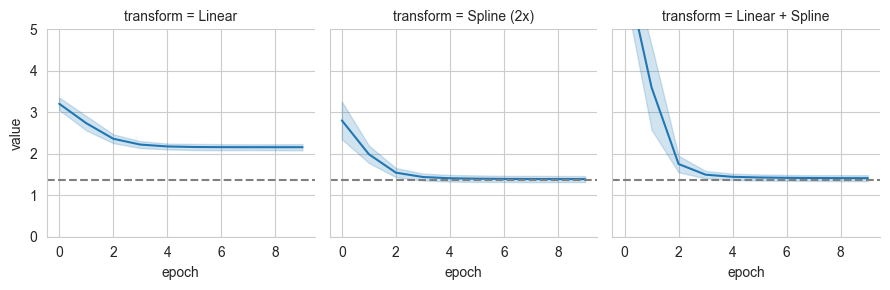

In [7]:
# Plot the estimated values of mutual information over time
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='transform', ylim=(0,5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

Text(0, 0.5, '$q(y)$')

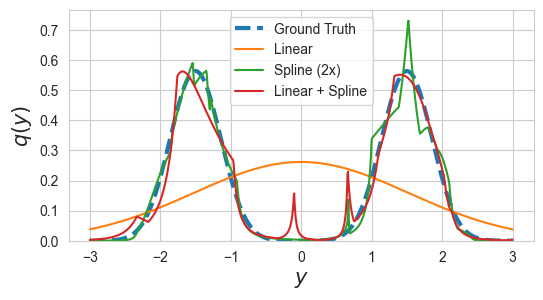

In [8]:
# Visualization of the ground truth and learned densities
y_grid = torch.linspace(-3,3, 1000).view(-1,1)

log_p_y = p_Y.log_prob(y_grid)

f, ax = plt.subplots(1,1, figsize=(IMG_SIZE*2, IMG_SIZE))
ax.plot(y_grid, log_p_y.exp(), label='Ground Truth', ls='--', linewidth=3)

for i, (name, q_X) in enumerate(marginal_dists.items()):
    log_r_y = q_X.log_prob(y_grid).data.numpy()
    ax.plot(y_grid, np.exp(log_r_y), label=name)
    
ax.legend()
ax.set_ylim(0)
ax.set_xlabel("$y$", fontsize=15)
ax.set_ylabel(f"$q(y)$", fontsize=15)


Note that more flexible variational densities result in more accurate estimation at the cost additional computation and memory. Since we are assuming $p(y|x)$ is known, the estimators will converge from above.

### Marginal Approximation Methods
A second strategy to estimate $H(y)$ revolves around non-parametric methods based on the marginalization of $p(y|x)$ (or its approximation $q_\theta(y|x)$).
$$
H(y) = -\mathbb{E}_{p(y)}\left[\log p(y)\right] = -\mathbb{E}_{p(y)}\left[ \log \mathbb{E}_{p(x)}[p(y|x)]\right].
$$

Therefore, for a batch of $N$ pairs $(x_i, y_i)$, this can be approximated as:
$$
H(y) \approx -\frac{1}{N}\sum_{i=1}^N \log \frac{1}{M}\sum_{j=1}^M p(y_i|x_{(i+j)\mod N}),
$$
in which $M$ refers to the number of samples $x$ used to marginalize $p(y|x)$ within one batch.
This estimator, known as Leave one Out (`L1Out`) for $M=N-1$ is biased because of the logarithm outside the inner-most expectation.

 
Contrastive Log-ratio Upper Bound (`CLUB`) makes use of Jensen inequality to push the log inside the expectation:
$$
H(y) = -\mathbb{E}_{p(y)}\left[ \log \mathbb{E}_{p(x)}[p(y|x)]\right] \le -\mathbb{E}_{p(y)}\mathbb{E}_{p(x)}[\log p(y|x)] \approx -\frac{1}{NM}\sum_{i=1}^N\sum_{j=1}^M \log p(y_i|x_{(i+j)\mod N}).
$$
Although the `CLUB` estimator for the entropy is unbiased, the bound in the equation above is generally not tight.


Analogously to the discriminative estimators, we refer to $M$ as `neg_samples` and negative values are used to specify a relative number w.r.t the batch size $N$. E.g. `neg_samples=-1` uses $M=N-1$ and for `neg_samples=0` we have $N=M$.

In [9]:
from torch_mist.estimators import CLUB, L1Out
from torch_mist.utils import evaluate_mi

estimators['L1Out'] = L1Out(
    q_Y_given_X=p_XY.conditional('x'),
    neg_samples=-1
)

estimators['CLUB'] = CLUB(
    q_Y_given_X=p_XY.conditional('x'),
    neg_samples=0
)


Note that the `L1Out` and `CLUB` estimators are non-parametric, therefore no training is require and we can directly compute estimates of mutual information.

In [10]:
estimates = []
# Estimate mutual information with all estimators
for name, estimator in estimators.items():
    print(f"Estimating I(x;y) with {name}")
    mi = evaluate_mi(
        estimator, 
        train_data=samples, 
        batch_size=128
    )
    
    estimates.append({'method': name, 'value': mi})
    
estimates = pd.DataFrame(estimates)

Estimating I(x;y) with Linear
Estimating I(x;y) with Spline (2x)
Estimating I(x;y) with Linear + Spline
Estimating I(x;y) with L1Out
Estimating I(x;y) with CLUB


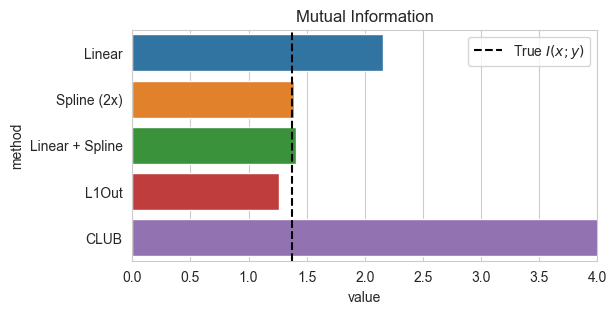

In [11]:
f, ax = plt.subplots(1,1, figsize=(IMG_SIZE*2, IMG_SIZE))
sns.barplot(estimates, y='method', x='value', ax=ax)
plt.axvline(x=true_mi, ls='--', color='k', label='True $I(x;y)$')
ax.set_title("Mutual Information")
ax.set_xlim(0,4)
ax.legend();

## Estimating Conditional Entropy
Throughout this section we will assume the marginal $p(y)$ is know and accessible as `p_Y`.


### Conditional Variational Approach

Similarly to $H(y)$, the conditional entropy $H(y|x)$ can be approximated by fitting a flexible normalized distribution $q_\theta(y|x)$ with learnable parameters $\theta$ using maximum likelihood.
The procedure to define such a distribution is analogous to the one described above when modeling $q_\phi(y)$ with the crucial difference that we model a conditional instead of a marginal distribution.

$$\mathcal{L}(\theta) = \mathbb{E}_{p(x,y)} [-\log q_\theta(y|x)]\ge H(y|x)$$

The `torch_mist` package also includes utilities to parametrize invertible conditional transformations by relying on `pyro.distributions.transforms.ConditionalTransform` and `pyro.distribution.ConditionalDistribution`.
Analogously to the marginal example above, we provide a `conditional_transformed_normal` factory to easily defined flexible conditional transformations of a standard Normal distribution:

$$
q_\theta(y|x) = \mathcal{N}(f_\theta^{-1}(y; x)|\mathbf{0},\mathbf{1})\left|\det\frac{\partial f_\theta(y;x)}{\partial y}\right|^{-1},
$$
in which $f_\theta^{-1}(y; x)$ refers to a conditional transform with parameters $\theta$. Note that $f_\theta(y;x)$ must be invertible on $y$ for every $x$ and it is commonly parametrized with neural networks.

Note that the `conditional_transformed_normal` factory supports both conditional and marginal transforms.

In [12]:
from torch_mist.distributions import conditional_transformed_normal

conditional_dists = {
    'Linear': conditional_transformed_normal(
        input_dim=y_dim,
        context_dim=x_dim,
        transform_name='linear',
    ), 
    'Conditional Linear': conditional_transformed_normal(
        input_dim=y_dim,
        context_dim=x_dim,
        transform_name='conditional_linear',
        hidden_dims=[64, 32]
    ), 
    'Conditional Spline (2x)': conditional_transformed_normal(
        input_dim=y_dim,
        context_dim=x_dim,
        transform_name='conditional_spline',
        hidden_dims=[32, 32],
        n_transforms=2,
    )
}

Analogously to the marginal case, customized transform lists can be specified by instantiating the `ConditionalTransformedNormalModule` class.

In [13]:
from torch_mist.distributions import ConditionalTransformedNormalModule

from pyro.distributions.transforms import conditional_spline
from torch_mist.distributions.transforms import conditional_linear

conditional_dists['Conditional (Linear + Spline)'] = ConditionalTransformedNormalModule(
    input_dim=y_dim,
    transforms=[
        conditional_linear(input_dim=y_dim, context_dim=x_dim, hidden_dims=[32, 32]),
        conditional_spline(input_dim=y_dim, context_dim=x_dim, hidden_dims=[32, 32], count_bins=10),
        linear(input_dim=y_dim)
    ]
)


Once again, we can estimate mutual information using the `DoE` estimator by specifing the known marginal $p(y)$:

$$
I(x;y) = H(y|x) - H(y) \ge \mathbb{E}_{p(x,y)}[\log q_\theta(y|x) + \log p(y)] \approx \frac{1}{N} \sum_{i=1}^N \log q_\theta(y_i|x_i) + \log p(y_i) 
$$

In [15]:
from torch_mist.estimators import DoE

estimators = {
    name: DoE(
        q_Y_given_X=conditional_dist, 
        q_Y=p_Y,
    ) for name, conditional_dist in conditional_dists.items()
}

pd_log = pd.DataFrame()
# Train all the estimators
for name, estimator in estimators.items():
    print(f"Training the MI estimator with the {name} transform")
    train_log = train_mi_estimator(
        estimator=estimator,
        train_data=samples,
        **train_parameters           
    )
    train_log['transform'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the MI estimator with the Linear transform


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Conditional Linear transform


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Conditional Spline (2x) transform


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Conditional (Linear + Spline) transform


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

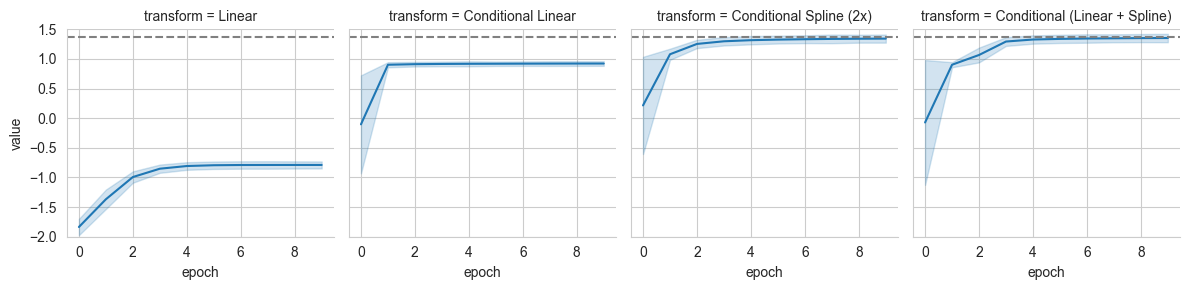

In [16]:
# Plot the estimated values of mutual information over time
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='transform', ylim=(-2,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

We can visualize the trained conditional distributions $q_\theta(y|x)$ and compare to the true conditional $p(y|x)$

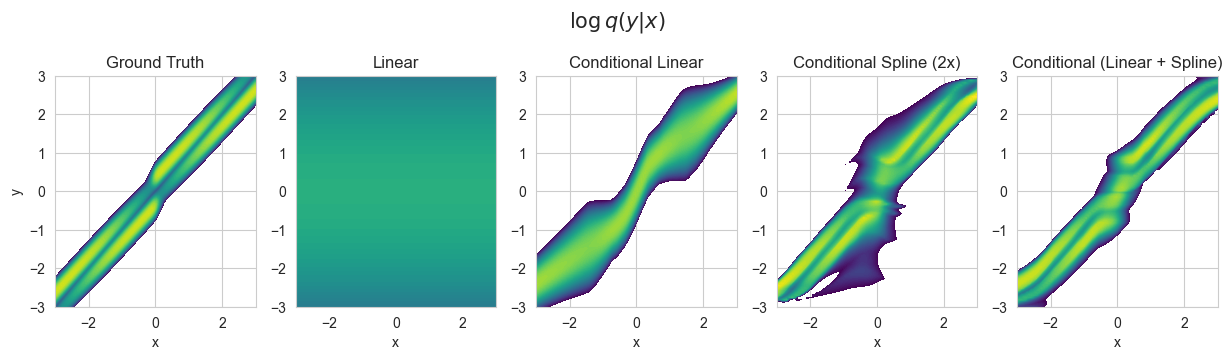

In [17]:
# We create a uniform grid to visualize the functions modeled by conditional distributions
res = 100
levels = list(np.linspace(-7,2,100))
x_grid = torch.linspace(-3,3,res).view(1,-1,1)
y_grid = torch.linspace(-3,3, res).view(-1,1,1)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the true p(y|x)
p_Y_given_x = p_XY.condition(x=x_grid.repeat(res,1,1))
log_p_y_given_x =p_Y_given_x.log_prob(y_grid.repeat(1,res,1))

# Plot the true log p(y|x)
f, ax = plt.subplots(
    1,len(conditional_dists)+1,
    figsize=((1+len(conditional_dists))*IMG_SIZE, IMG_SIZE)
)

f.suptitle("$\\log q(y|x)$", fontsize=15, y=1.1)
p=ax[0].contourf(X, Y, log_p_y_given_x, cmap='viridis', levels=levels)
ax[0].set_title('Ground Truth')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')


# And the unnormalized log-ratio modeled by the critics
for i, (name, q_Y_given_X) in enumerate(conditional_dists.items()):
    q_Y_given_x = q_Y_given_X.condition(x_grid.repeat(res, 1, 1))
    log_q_y_given_x = q_Y_given_x.log_prob(y_grid.repeat(1, res, 1)).data.numpy()
    ax[i+1].contourf(X, Y, log_q_y_given_x, cmap='viridis', levels=levels)
    ax[i+1].set_title(name)
    ax[i+1].set_xlabel('x')
    

Text(0, 0.5, '$q(y|x=1.0)$')

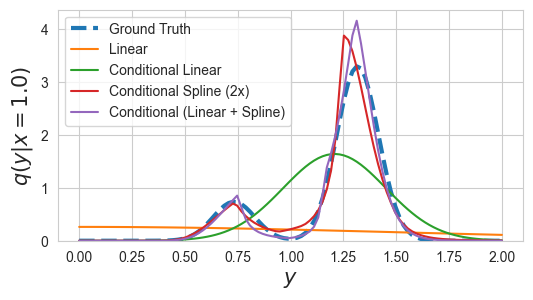

In [18]:
# We can visualize the conditional distribution evaluated on x_0=1.0
x_0 = torch.FloatTensor([1.0]).view(1,1)
y_grid = torch.linspace(0,2, res).view(-1,1)

p_Y_given_x_0 = p_XY.conditional('x').condition(x_0)
log_p_y_given_x_0= p_Y_given_x_0.log_prob(y_grid)

f, ax = plt.subplots(1,1, figsize=(IMG_SIZE*2, IMG_SIZE))
ax.plot(y_grid, log_p_y_given_x_0.exp(), label='Ground Truth', ls='--', linewidth=3)

for i, (name, q_Y_given_X) in enumerate(conditional_dists.items()):
    q_Y_given_x_0 = q_Y_given_X.condition(x_0)
    q_y_given_x_0 = q_Y_given_x_0.log_prob(y_grid).exp().data.numpy()
    ax.plot(y_grid, q_y_given_x_0, label=name)
    
ax.legend()
ax.set_ylim(0)
ax.set_xlabel("$y$", fontsize=15)
ax.set_ylabel(f"$q(y|x={x_0.item()})$", fontsize=15)

The flexibility of $q(y|x)$ determines the accuracy the estimation of $I(x;y)$ and the computational costs. Note that since we assume $p(y)$ is known, the estimations converge to the true mutual information from below.

### Joint Variational Approach

Instead of estimating $H(y|x)$ directly, one could express it as a difference between the joint and marginal entropy
$$
H(y|x) = H(x,y) - H(x),
$$
and approximate $H(x,y)$ and $H(x)$ instead.
This requires introducing two variational distributions $q_\theta(x,y)$ and $q_\psi(x)$, which can be trained using samples from $p(x,y)$.

$$
H(y|x) \approx \mathbb{E}_{p(x,y)}[-\log q_\theta(x,y) + \log q_\psi(x)]
$$

Whenever neither the joint nor the marginal distributions are known, the approximation above does not represent an upper or lower bound of MI. The accuracy of the estimation depends on the divergence between the variational distributions and the corresponding ground-truth:

$$
\mathbb{E}_{p(x,y)}[-\log q_\theta(x,y) + \log q_\psi(x)] = H(y|x) +\underbrace{KL(p(x)||q_\psi(x))- KL(p(x,y)||q_\theta(x,y))}_{\text{Approximation Gap}} 
$$


In [24]:
from torch_mist.distributions import joint_transformed_normal

# We define some simple marginal and joint parametric transformations
marginal_dists = {
    'Linear': transformed_normal(
        input_dim=x_dim,
        transform_name='linear'
    ),
    'Spline': transformed_normal(
        input_dim=x_dim,
        transform_name='spline',
        count_bins=10
    )
}

joint_dists = {
    'Linear': joint_transformed_normal(
        input_dims = {'x': x_dim, 'y': y_dim},
        transform_name='linear'
    ),
    'Spline autoregressive': joint_transformed_normal(
        input_dims = {'x': x_dim, 'y': y_dim},
        transform_name='spline_autoregressive',
        n_transforms=2
    )
}

In [30]:
from torch_mist.estimators import GM
from copy import deepcopy

pd_log = pd.DataFrame()

estimators = {}

# Train the estimators obtained by combining all marginals and joints
for marginal_name, q_X in marginal_dists.items():
    for joint_name, q_XY in joint_dists.items():
        estimators[f"{marginal_name} marginal, {joint_name} joint"] = GM(
            q_Y=p_Y,
            q_X=deepcopy(q_X),
            q_XY=deepcopy(q_XY),
        )

for name, estimator in estimators.items():
    print(f"Training the MI estimator with the {name} transforms")
    train_log = train_mi_estimator(
        estimator=estimator,
        train_data=samples,
        **train_parameters           
    )
    train_log['distributions'] = name
    pd_log = pd.concat([pd_log, train_log])
        

Training the MI estimator with the Linear marginal, Linear joint transforms


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Linear marginal, Spline autoregressive joint transforms


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Spline marginal, Linear joint transforms


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Spline marginal, Spline autoregressive joint transforms


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

In [35]:
pd_log['distributions'].unique()

array(['Linear marginal, Linear joint',
       'Linear marginal, Spline autoregressive joint',
       'Spline marginal, Linear joint',
       'Spline marginal, Spline autoregressive joint'], dtype=object)

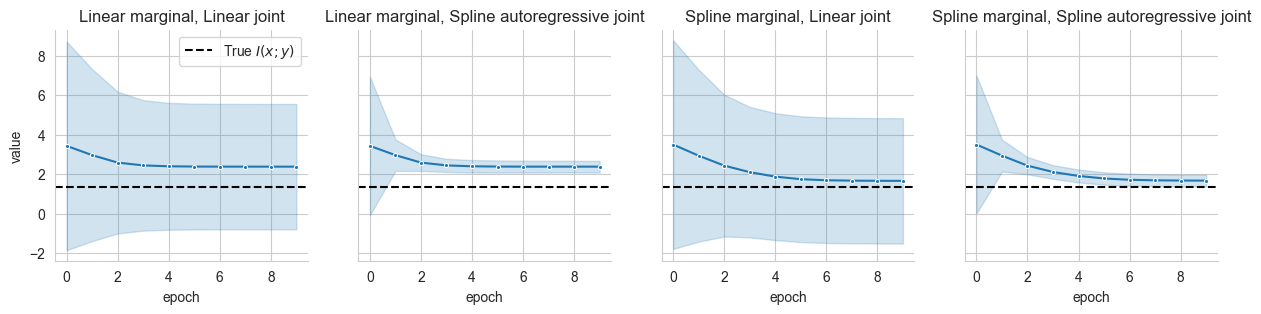

In [36]:
# Plot the estimated values of mutual information over time
f, ax = plt.subplots(
    1, len(marginal_dists)*len(joint_dists), 
    figsize=(len(marginal_dists)*len(joint_dists)*IMG_SIZE+3,IMG_SIZE), 
    sharey=True
)
sns.despine()

for i, name in enumerate(pd_log['distributions'].unique()):
    ax[i].set_title(name)
    ax[i].axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
    sns.lineplot(pd_log[pd_log['distributions']==name], x='epoch', y='value', marker='.', ax=ax[i], legend=i==0, errorbar='sd')



Wherever the joint distribution is more flexible than the marginal, the estimator tends to overestimate MI:
$$
    KL(p(x)||q_\psi(x))>KL(p(x,y)||q_\theta(x,y)).
$$
When the marginal is more flexible than the joint, (or as flexible), the estimates tends to underestimate the true value:
$$
    KL(p(x)||q_\psi(x))<KL(p(x,y)||q_\theta(x,y)).
$$
The estimate is accurate whenever both the marginal and the joint distribution are flexible.

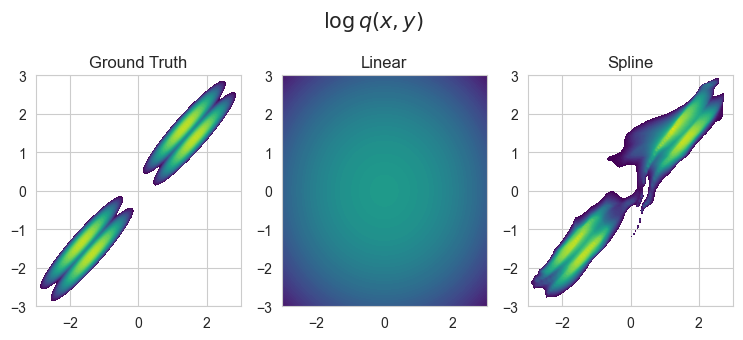

In [37]:
# We create a uniform grid to visualize the functions modeled by conditional distributions
res = 100
levels = list(np.linspace(-7,1,100))
x_grid = torch.linspace(-3,3,res).view(1,-1,1)
y_grid = torch.linspace(-3,3, res).view(-1,1,1)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the true p(y|x)
log_p_yx =p_XY.log_prob(x=x_grid.repeat(res,1,1), y=y_grid.repeat(1,res,1))


# Plot the true log p(y|x)
f, ax = plt.subplots(
    1,len(joint_dists)+1,
    figsize=((1+len(joint_dists))*IMG_SIZE, IMG_SIZE)
)

f.suptitle("$\\log q(x,y)$", fontsize=15, y=1.1)
p=ax[0].contourf(X, Y, log_p_yx, cmap='viridis', levels=levels)
ax[0].set_title('Ground Truth')

# And the unnormalized log-ratio modeled by the critics
for i, (name, q_XY) in enumerate({
    'Linear': estimators['Linear marginal, Linear joint'].q_XY,
    'Spline': estimators['Spline marginal, Spline autoregressive joint'].q_XY
}.items()):
    log_q_xy = q_XY.log_prob(x=x_grid.repeat(res,1,1), y=y_grid.repeat(1,res, 1)).data.numpy()
    ax[i+1].contourf(X, Y, log_q_xy, cmap='viridis', levels=levels)
    ax[i+1].set_title(name)
    

## Summary




A summary of the estimators and approximation strategies for a batch on $N$ samples $(x_i, y_i)\stackrel{N}{\sim} p(x,y)$ is reported below.



| Estimator | $H(y)$                                                                                                        | $H(y|x)$                                                                                | Bound                                                                                    |
|-----------|---------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| DoE       | $-\frac{1}{N}\sum_{i=1}^N \log q_\phi(y_i)$                                                                   | $-\frac{1}{N}\sum_{i=1}^N \log q_\theta(y_i| x_i)$                                      | Upper bound for  $q_\theta(y|x)=p(y|x)$, lower bound for $q_\phi(y)=p(y)$              | 
| BA        | Given                                                                                                         | $-\frac{1}{N}\sum_{i=1}^N \log q_\theta(y_i| x_i)$                                      | Lower bound                                                                              |
| GM        | $-\frac{1}{N}\sum_{i=1}^N \log q_\phi(y_i)$                                                                   | $-\frac{1}{N}\sum_{i=1}^N \log\frac{q_\theta(x_i, y_i)}{q_\psi(x_i)}$                    | Upper bound for $q_\theta(x, y)=p(x,y)$, lower bound for $q_\phi(y)=p(y),q_\psi(x)=p(x)$ |
| L1Out     | $-\frac{1}{N}\sum_{i=1}^N \log \frac{1}{M}\sum_{j=1}^M q_\theta(y_i| x_{(i+j)\mod N})$                       | $-\frac{1}{N}\sum_{i=1}^N \log q_\theta(y_i| x_i)$                                      | No                                                                                       |
| CLUB      | $-\frac{1}{MN}\sum_{i=1}^N\sum_{j=1}^M \log q_\theta(y_i                                 | x_{(i+j)\mod N})$ | $-\frac{1}{N}\sum_{i=1}^N \log q_\theta(y_i| x_i)$                                                                                          | Upper bound for $q_\theta(y|x)=p(y|x)$                                                 |

All variational models are trained using maximum likelihood.